In [1]:
from dbnet import model
import numpy as np
import json
import glob

import os

import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from datetime import datetime

def get_timestamp() -> str:
    timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    return timestamp
import cv2


import tensorflow_addons as tfa

In [2]:
# builder: dbnet_fpn
# options:
#   input_shape: [1344, 1024, 3]
#   fpn_channels: 192
#   backbone: mobile_small_mini
#   k: 50
#   prob_init: 0.0001
#   threshold_init: 0.0001
#   kernel_init: he_normal

train_model = model.dbnet_model.dbnet_fpn(
    input_shape=[None,None,3],
    fpn_channels=192,backbone='mobile_small_mini',
    k=50,prob_init=0.0001,
    threshold_init=0.0001,
    kernel_init='he_normal'
)
train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           image[0][0]                      
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, None, None, 1 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, None, None, 1 64          Conv[0][0]                       
______________________________________________________________________________________________

In [3]:
with open("./save_500_int.json") as f:
    labels = json.load(f)["_via_img_metadata"]

In [4]:
images = []
for k,v in labels.items():
    images.append(v['filename'])
images = sorted(images)
# images

In [5]:
def split_data(images, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    images = np.array(images)
    size = len(images) 
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(images)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
   
    
    threshold_map = list(map(lambda x: './threshold_map/'+x, images))
    train_threshold_map,valid_threshold_map = threshold_map[:train_samples] , threshold_map[train_samples:]
    threshold_mask = list(map(lambda x: './threshold_mask/'+x, images))
    train_threshold_mask,valid_threshold_mask = threshold_mask[:train_samples] , threshold_mask[train_samples:]
    shrink_map = list(map(lambda x: './shrink_map/'+x, images))
    train_shrink_map,valid_shrink_map = shrink_map[:train_samples] , threshold_mask[train_samples:]
    images = list(map(lambda x: '/datasets/almex_insurance/img/'+x, images))
    x_train,x_valid = images[:train_samples],images[train_samples:]
    
    return x_train, x_valid,train_threshold_map,valid_threshold_map,train_threshold_mask,valid_threshold_mask,train_shrink_map,valid_shrink_map
x,v,y1,vy1,y2,vy2,y3,vy3 = split_data(images,train_size=0.9)

In [6]:

a= 214557-168448
b=56158-46552
a+b


55715

In [7]:
def imshow(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()

In [8]:
@tf.function
def encode_single_sample(x,y1,y2,y3):
    # 1. Read image
    img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    threshold_map = tf.io.read_file(y1)
    threshold_map = tf.io.decode_jpeg(threshold_map, channels=1)
    threshold_map = tf.image.convert_image_dtype(threshold_map, tf.float32)
    s = tf.cast(tf.shape(threshold_map),tf.int32)
    
    img = tf.image.resize(img,(s[0],s[1]),method="area")
    
        
    threshold_mask = tf.io.read_file(y2)
    threshold_mask = tf.io.decode_jpeg(threshold_mask, channels=1)
    threshold_mask = tf.image.convert_image_dtype(threshold_mask, tf.float32)
    
    
    shrink_map = tf.io.read_file(y3)
    shrink_map = tf.io.decode_jpeg(shrink_map, channels=1)
    shrink_map = tf.image.convert_image_dtype(shrink_map, tf.float32)
    
    #random rorate
    angle = tf.random.uniform([],0,3.14/180*5)
    
    img = tfa.image.rotate(img,angle)
    shrink_map = tfa.image.rotate(shrink_map,angle)
    threshold_map = tfa.image.rotate(threshold_map,angle)
    threshold_mask = tfa.image.rotate(threshold_mask,angle)
    
    if tf.random.uniform([],0,1) > 0.5:
        img = tf.image.flip_left_right(img)
        shrink_map = tf.image.flip_left_right(shrink_map)
        threshold_map = tf.image.flip_left_right(threshold_map)
        threshold_mask = tf.image.flip_left_right(threshold_mask)

    img = tf.image.random_jpeg_quality(img, min_jpeg_quality=50, max_jpeg_quality=100)
#   img = tf.clip_by_value(tf.cast(img, tf.float32), clip_value_min=0., clip_value_max=255.)
#   # rand brightness is turned off b/c training data already has a variety of lighting
# #   img = tf.image.random_brightness(img, max_delta=0.3)

    img = tf.clip_by_value(img, 0. , 255.)
    img = tf.image.random_contrast(img, lower=0.85, upper=1.15)
    img = tf.clip_by_value(img, 0. , 255.)
    img = tf.image.random_hue(img, max_delta=0.25)
    img = tf.clip_by_value(img, 0. , 255.)
    img = tf.image.random_saturation(img, lower=0.85, upper=1.15)
    img = tf.clip_by_value(img, 0. , 255.)
    
    th = tf.concat([threshold_map,threshold_mask],axis=-1)
    
#     return {"image": img, "threshold_map": threshold_map,"threshold_mask": threshold_mask,"shrink_map":shrink_map}
    return {"image": img},{"prob":shrink_map,"threshold": th,"binary": shrink_map}
#     return {"image": img,"prob":shrink_map,"threshold": threshold_map}


In [9]:
batch_size = 1

train_dataset = tf.data.Dataset.from_tensor_slices((x,y1,y2,y3))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((v,vy1,vy2,vy3))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


(1, 736, 1184, 3)


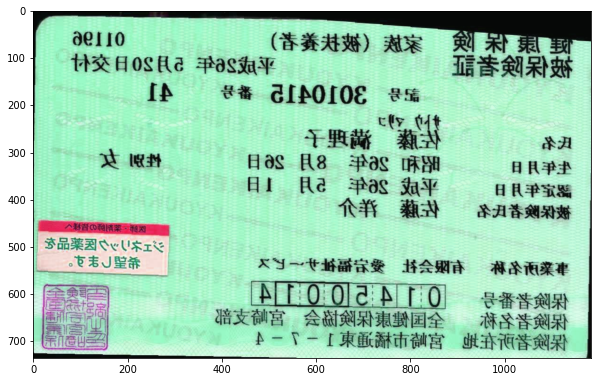

(1, 736, 1184, 1)


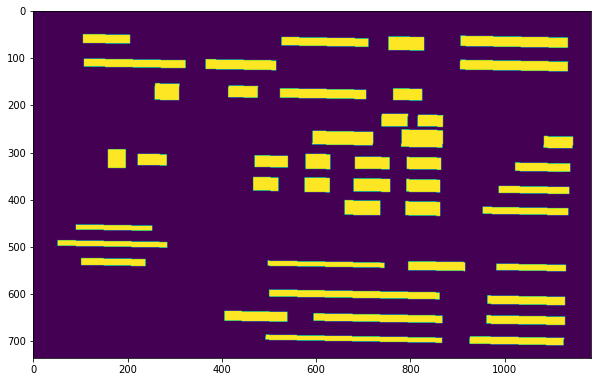

(1, 736, 1184, 2)


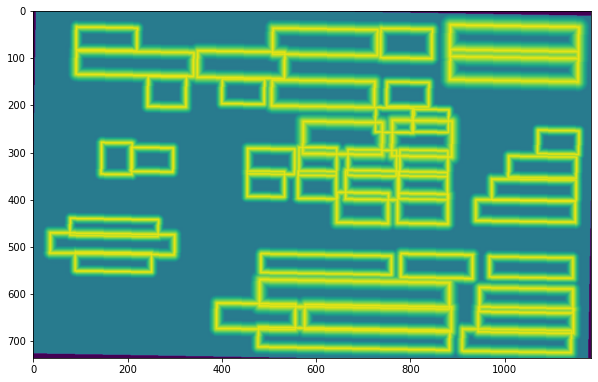

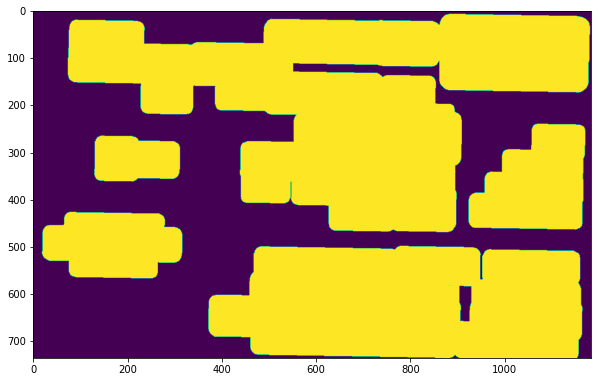

In [10]:
for i in train_dataset.take(1):
    print(i[0]['image'].shape)
    imshow(i[0]['image'][0,...])
    print(i[1]['prob'].shape)
    imshow(i[1]['prob'][0,...])
    print(i[1]['threshold'].shape)
    imshow(i[1]['threshold'][0,...,0])
    imshow(i[1]['threshold'][0,...,1])
#     imshow(i[1]['binary'][0,...])
    
    

In [11]:
# for i in train_dataset.take(1):
#     print(i['image'].shape)
#     imshow(i['image'][0,...])
#     imshow(i['prob'][0,...])
#     imshow(i['threshold'][0,...])
#     imshow(i['binary'][0,...])
#     break

In [12]:
epochs = 30
early_stopping_patience = 3 
filepath = get_timestamp() + '.ckpt'

# import dbnet.trainer.optimizer as optimizer 


# opt = getattr(optimizer, 'RectifiedAdam')(amsgrad=True)
# opt = tfa.optimizers.RectifiedAdam(amsgrad=True)
# opt = tfa.optimizers.Lookahead(opt)
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)

import dbnet.trainer.loss as loss
# loss:
#   prob: bce
#   threshold: l1
#   binary: dice
loss_parameter = {'prob':'bce','threshold':'l1','binary':'dice'} 

losses = {k: getattr(loss, v) for k, v in loss_parameter.items()}

losses


{'prob': <function dbnet.trainer.loss.bce.bce(y_true, y_pred, neg_ratio=3.0, eps=1e-06)>,
 'threshold': <function dbnet.trainer.loss.l1.l1(y_true, y_pred, eps=1e-06)>,
 'binary': <function dbnet.trainer.loss.dice.dice(y_true, y_pred, eps=1e-06)>}

In [13]:
# weights:
#   prob: 1.0
#   threshold: 10.0
#   binary: 1.0
weights = {'prob':1.0,'threshold':10.0,'binary':1.0}

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',verbose = 1,save_best_only=True,save_weights_only=True,mode='auto')
# early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",patience=early_stopping_patience,restore_best_weights=True)
opt = keras.optimizers.Adam()
# opt = tfa.optimizers.Lookahead(opt)
train_model.compile(optimizer=opt,loss=losses,loss_weights=weights)

train_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
#     steps_per_epoch=500,
#     callbacks=[early_stopping,checkpoint],
    callbacks=[checkpoint]
)

In [ ]:
# optimizer:
#   name: RectifiedAdam
#   options:
#     amsgrad: true
#   lookahead: true
#   mixed_precision: true

## interface

In [ ]:
# train_model.load_weights('/workspace/dbnet.release.lin/2021_11_17_07_56_22.ckpt')


In [25]:
pred_model =  keras.Model(inputs=train_model.get_layer('image').input,outputs=train_model.get_layer('prob').output)

In [ ]:
# from dbnet.dataset import TFRecordLoader
# tfloader = TFRecordLoader()
# data = tfloader.get_ds_from('./conf/lin_train.yaml')

In [ ]:
# for i in data.take(1):
#     print(i[0]['image'].shape)
#     imshow(i[0]['image'][])
#     break

In [ ]:
# print(i[0]['image'].shape)
# imshow(i[0]['image'][0,...]/255)
# print(i[1]['threshold'].shape)
# imshow(i[1]['threshold'][0,...,0])
# imshow(i[1]['threshold'][0,...,1])

In [ ]:
# for x,i in enumerate(validation_dataset.take(5)):
#     print(i[0]['image'].shape)
#     imshow(i[0]['image'][0,...]/255)
#     print(i[1]['threshold'].shape)
# #     imshow()
#     if x == 5:
#         break

In [26]:
# workspace/dbnet.release.lin/photo_2021-06-21_10-37-15.jpg
# workspace/dbnet.release.lin/r2hokensyo-kazoku.png
# workspace/dbnet.release.lin/zumen.jpg
img = cv2.imread('r2hokensyo-kazoku.png')[...,:3]/255

h,w = img.shape[:2]
print(h,w)

new_h = int((h//32)*32)
new_w = int((w//32)*32)
new_h,new_w

img = cv2.resize(img,(new_w,new_h))



924 1480


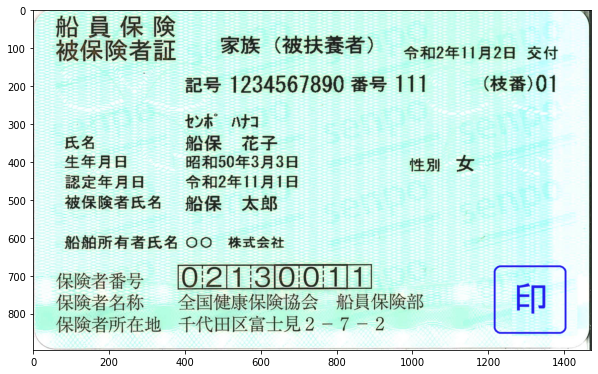

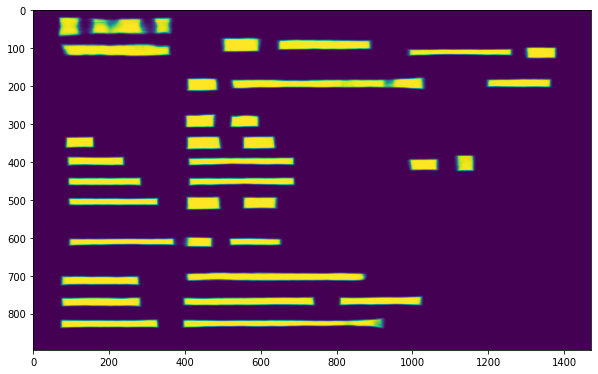

In [27]:
imshow(img)
# res = pred_model.predict(i[0]['image'])
res = pred_model.predict(img[np.newaxis,...])
imshow(res[0,...])

In [28]:
import pyclipper
from shapely.geometry import Polygon


In [29]:
def parse_result(result: np.ndarray):
    th = 0.1
    result = result[0, ..., 0]
    res_exp = np.exp(result)
    result = res_exp / (res_exp + 1)
    imshow(result)
    mask = result > th
    h, w = mask.shape
    contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    return contours

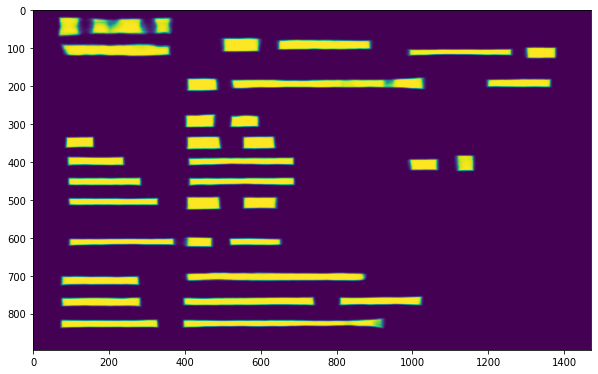

[array([[[   0,    0]],
 
        [[   0,  895]],
 
        [[1471,  895]],
 
        [[1471,    0]]], dtype=int32)]

In [30]:
c = parse_result(res)
c

In [31]:
th = 100

result = (res[0,...,0]*255).astype(np.uint8)
mask = result > th
contours, _ = cv2.findContours((mask*255).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
boxs=[]
bboxs=[]
ptss = []
for contour in contours:
    bbox = cv2.minAreaRect(contour)
    box = cv2.boxPoints(bbox)
#     print(cv2.boxPoints(bbox))
    pts = sorted(list(cv2.boxPoints(bbox)), key=lambda x: x[0])
#     print(pts)
    
    if pts[1][1] > pts[0][1]:
        idx1, idx4 = 0, 1
    else:
        idx1, idx4 = 1, 0
    if pts[3][1] > pts[2][1]:
        idx2, idx3 = 2, 3
    else:
        idx2, idx3 = 3, 2
#     box = np.array(pts)[[idx1, idx2, idx3, idx4], ...]
#     print(box)
# # #     boxs.append(box)
# # #     bboxs.append(bbox)
# # #     ptss.append(pts)
    ssize = min(bbox[1])
    if ssize > 5:
        bboxs.append(box)


In [32]:
def unclip(box, unclip_ratio):
    poly = Polygon(box)
    distance = poly.area * unclip_ratio / poly.length
    offset = pyclipper.PyclipperOffset()
    offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
    expanded = np.array(offset.Execute(distance))
    return expanded



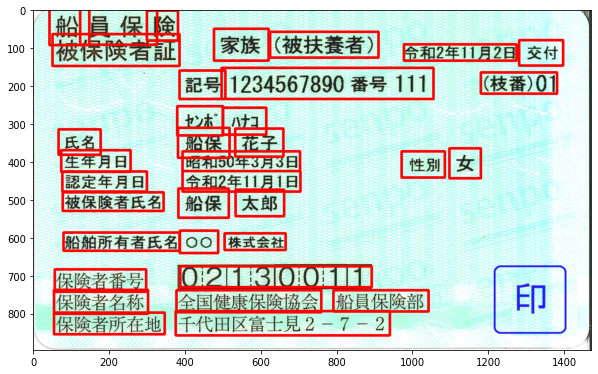

In [48]:
res_copy = img.copy()
# res_copy=res[0,...,0].copy()
for box in bboxs:
    big_box = unclip(box,2)
#     print(big_box)
    x_max = np.max(big_box[0,:,0])
    x_min = np.min(big_box[0,:,0])
    y_max = np.max(big_box[0,:,1])
    y_min = np.min(big_box[0,:,1])
    rect = cv2.rectangle(res_copy,(x_max,y_min),(x_min,y_max),1,5)
imshow(res_copy)

In [34]:
import re

In [45]:
p = re.compile(r'([\d]+)割')
s= '32割'

In [46]:
p.findall(s)

['32']